## Creating the dataset and training the model

In [1]:
# import the packages
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch 
import torchaudio
from torch.utils.data import DataLoader, random_split

import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns


from utils import *
from model import BirdAudioClassifierModel, ModelTrainer, ModelTester

### Checking if cuda is available

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A500 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Creating a Custom Dataset

In [3]:
#load metadata df 
current_dir = os.getcwd() 
file_name = "Dataset\\metadata.csv"
file_path = os.path.join(current_dir, file_name) 
df_metadata = pd.read_csv(file_path)
display(df_metadata)

,file_id,original_file_id,english_cname,relative_path,class_id
0,1,101371,Long-tailed Tit,Dataset\preprocessed_songs\1.flac,0
1,2,101371,Long-tailed Tit,Dataset\preprocessed_songs\2.flac,0
2,3,101371,Long-tailed Tit,Dataset\preprocessed_songs\3.flac,0
3,4,101371,Long-tailed Tit,Dataset\preprocessed_songs\4.flac,0
4,5,101371,Long-tailed Tit,Dataset\preprocessed_songs\5.flac,0
...,...,...,...,...,...
3543,3544,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3544.flac,75
3544,3545,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3545.flac,75
3545,3546,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3546.flac,75
3546,3547,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3547.flac,75


In [4]:
##splitting the dataset with uniform class_id distribution (ensure that the each of the datasets has an appropriate amout of example from each class)

#split the data into training and temp sets(80% training, 20% temp)
df_train, df_temp = train_test_split(df_metadata, test_size=0.2, stratify=df_metadata["class_id"], random_state=42)
# split the temp set into testing and validation sets (50% each)
df_test, df_val = train_test_split(df_temp, test_size=0.5, stratify=df_temp["class_id"], random_state=42)

#resetting the indices to avoid indexing errors when loading data using the custom AudioDataSet 
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# Print the sizes of the splits
print("Training set size:", len(df_train))
print("Testing set size:", len(df_test))
print("Validation set size:", len(df_val))

# You can access the class distribution in each set using value_counts
print("Training set class distribution:\n", df_train["class_id"].value_counts())
print("Testing set class distribution:\n", df_test["class_id"].value_counts())
print("Validation set class distribution:\n", df_val["class_id"].value_counts())

Training set size: 2838
Testing set size: 355
Validation set size: 355
Training set class distribution:
 class_id
31    120
32     93
33     90
69     85
22     81
     ... 
3      11
48     10
20      9
19      8
81      8
Name: count, Length: 88, dtype: int64
Testing set class distribution:
 class_id
31    15
33    12
32    12
22    11
69    10
      ..
75     1
54     1
55     1
81     1
42     1
Name: count, Length: 88, dtype: int64
Validation set class distribution:
 class_id
31    15
32    12
33    11
69    11
7     10
      ..
77     2
19     1
48     1
20     1
81     1
Name: count, Length: 88, dtype: int64


In [5]:
#create the datasets and data loaders 
#create the training, validaiton and testing datasets 
train_dataset = AudioDataSet(df_metadata=df_train, base_dir=current_dir)
val_dataset = AudioDataSet(df_metadata=df_val, base_dir=current_dir)
test_dataset = AudioDataSet(df_metadata=df_test, base_dir=current_dir)

#create the training, validation and test data loaders  (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

#print the lengths of each set
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 2838
Validation set size: 355
Test set size: 355


Shape of spectrograms: torch.Size([16, 1, 401, 552]), Class ids: tensor([32, 25, 14, 45,  9, 65, 69, 16, 39,  0, 75, 77, 18,  2, 52, 50])


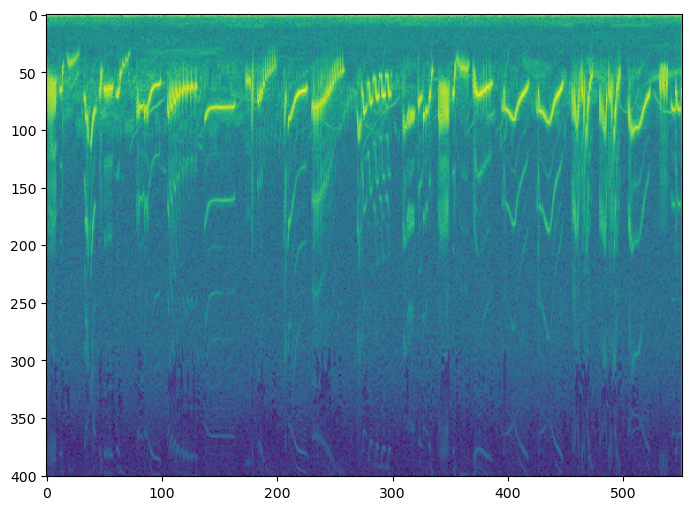

In [6]:
#test data loaders 
spectrograms, class_id = next(iter(train_dataloader)) 
print(f"Shape of spectrograms: {spectrograms.size()}, Class ids: {class_id}")
plt.figure(figsize=(10, 6))
plt.imshow(spectrograms[0,0,:,:].numpy())

### Creating the model
Each batch has a shape of (batch_size, num_channels, frequency_bands, time_steps). This means that each input (each spectrogram) is of size frequency_bands x time_steps which in our case is 401 x 552 = 221352.

The audio has not been transformed to spectrogram images so now we can use standard image classification techniques. This means we are going to use a CNN model to classify the spectrogram images. (image classification paper/source) 


In [9]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

In [10]:
# class BirdAudioClassifier(nn.Module): 
#     def __init__(self, num_classes=88): 
#         super().__init__() 
#         #define the different layers 
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3) #number of input channels, number of output channels (number of filters that will be applied), 
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
#         #define max pooling 
#         self.max_pool = nn.MaxPool2d(2, 2)
#         #layer to flatten the output 
#         self.flatten = nn.Flatten() 
#         #fully connected layer for classification 
#         self.fc1 = nn.Linear(411648, 512)
#         self.fc2 = nn.Linear(512, num_classes)
    
#     #implement the forward propagation through the network
#     def forward(self, x): 
#         #first convolutional layer + relu + max pool layer
#         x = self.max_pool(F.relu(self.conv1(x)))
#         #second convolutional layer + relu + max pool layer
#         x = self.max_pool(F.relu(self.conv2(x)))
#         #third convolutional layer + relu + max pool layer
#         x = self.max_pool(F.relu(self.conv3(x)))
#         #flatten the output from the convolutional layer 
#         x = self.flatten(x) 
#         #first fully connected layer 
#         x = F.relu(self.fc1(x)) 
#         #second fully connected layer 
#         x = self.fc2(x) 
#         #softmax activation function to convert the logits to log probabilities
#         x = F.log_softmax(x, dim=1)
#         return x

### Training the model

In [11]:
#train model
model = BirdAudioClassifierModel(num_classes=88)
#create trainer 
model_trainer = ModelTrainer(model=model, learning_rate=0.0001)
num_epochs = 8 #instead of 15 to avoid overfitting

train_losses, val_losses = model_trainer.train(num_epochs=num_epochs, 
                                                train_dataloader=train_dataloader, 
                                                test_dataloader=val_dataloader)

'''
For report: 
On the 'Training and Validation Loss Over Epochs' plot we can see that the validation loss 
starts to increase after the 8th epoch which means that the model is starting to overfit which 
results in it being to specialized on the training data and becoming worse at generalizing. 


'''
print(train_losses) 
print(val_losses)

#saving the trained model
# model_trainer.save_model('Models\model3.pth')



Epoch 1
-------------------------------
loss: 4.958231  [    0/ 2838]
loss: 4.238914  [  400/ 2838]
loss: 3.508895  [  800/ 2838]
loss: 3.731770  [ 1200/ 2838]
loss: 2.760575  [ 1600/ 2838]
loss: 3.367612  [ 2000/ 2838]
loss: 2.651975  [ 2400/ 2838]
loss: 1.756197  [ 2800/ 2838]

Test Error:
acc: 56.9%, avg loss: 0.127391

Epoch 2
-------------------------------
loss: 1.537642  [    0/ 2838]
loss: 1.551194  [  400/ 2838]
loss: 1.240581  [  800/ 2838]
loss: 1.375311  [ 1200/ 2838]
loss: 0.623137  [ 1600/ 2838]
loss: 0.749945  [ 2000/ 2838]
loss: 0.292749  [ 2400/ 2838]
loss: 0.446553  [ 2800/ 2838]

Test Error:
acc: 69.0%, avg loss: 0.082185

Epoch 3
-------------------------------
loss: 0.640766  [    0/ 2838]
loss: 0.191929  [  400/ 2838]
loss: 0.090350  [  800/ 2838]
loss: 0.567417  [ 1200/ 2838]
loss: 0.361131  [ 1600/ 2838]
loss: 0.392237  [ 2000/ 2838]
loss: 0.154293  [ 2400/ 2838]
loss: 0.127340  [ 2800/ 2838]

Test Error:
acc: 78.6%, avg loss: 0.062967

Epoch 4
-----------------

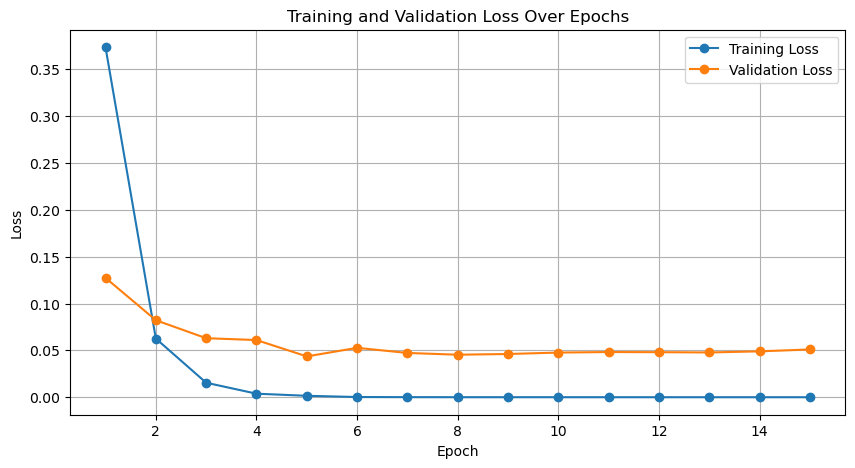

In [12]:
#plot the loss training loss over the validation loss 

#create epoch list
epochs = [i+1 for i in range(num_epochs)]

# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Save the plot as an image file
# plt.savefig('Models\loss_plot_model3.png')
plt.show()

### Model Evaluation 
Evaluating model performance on test dataset

In [46]:
#Create the model
num_bird_classes = 88
model = BirdAudioClassifierModel(num_classes=num_bird_classes)
#load the trained model 
model.load_state_dict(torch.load('Models\model2.pth'))

<All keys matched successfully>

In [47]:
modelTester = ModelTester(model=model, test_dataloader=test_dataloader)

In [48]:
# print accuracy, overall performance
print(f"Accuracy: {round(modelTester.get_accuracy()*100, 2)}%")
#print precision, accuracy of the positive predictions made by the classifier.
print(f"Rrecision: {round(modelTester.get_precision()*100, 2)}%")
#print recall, rate of correct positive predictions over all positives
print(f"Recall: {round(modelTester.get_recall()*100, 2)}%")
#print F1 score, The harmonic mean of precision and recall
print(f"F1 score: {round(modelTester.get_F1_score()*100, 2)}%")

Accuracy: 83.66%
Rrecision: 83.66%
Recall: 83.66%
F1 score: 83.66%


In [49]:
confusion_matrix = modelTester.get_confusion_matrix()
print(f"confusion matrix: {confusion_matrix}")

confusion matrix: [[0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 3]]


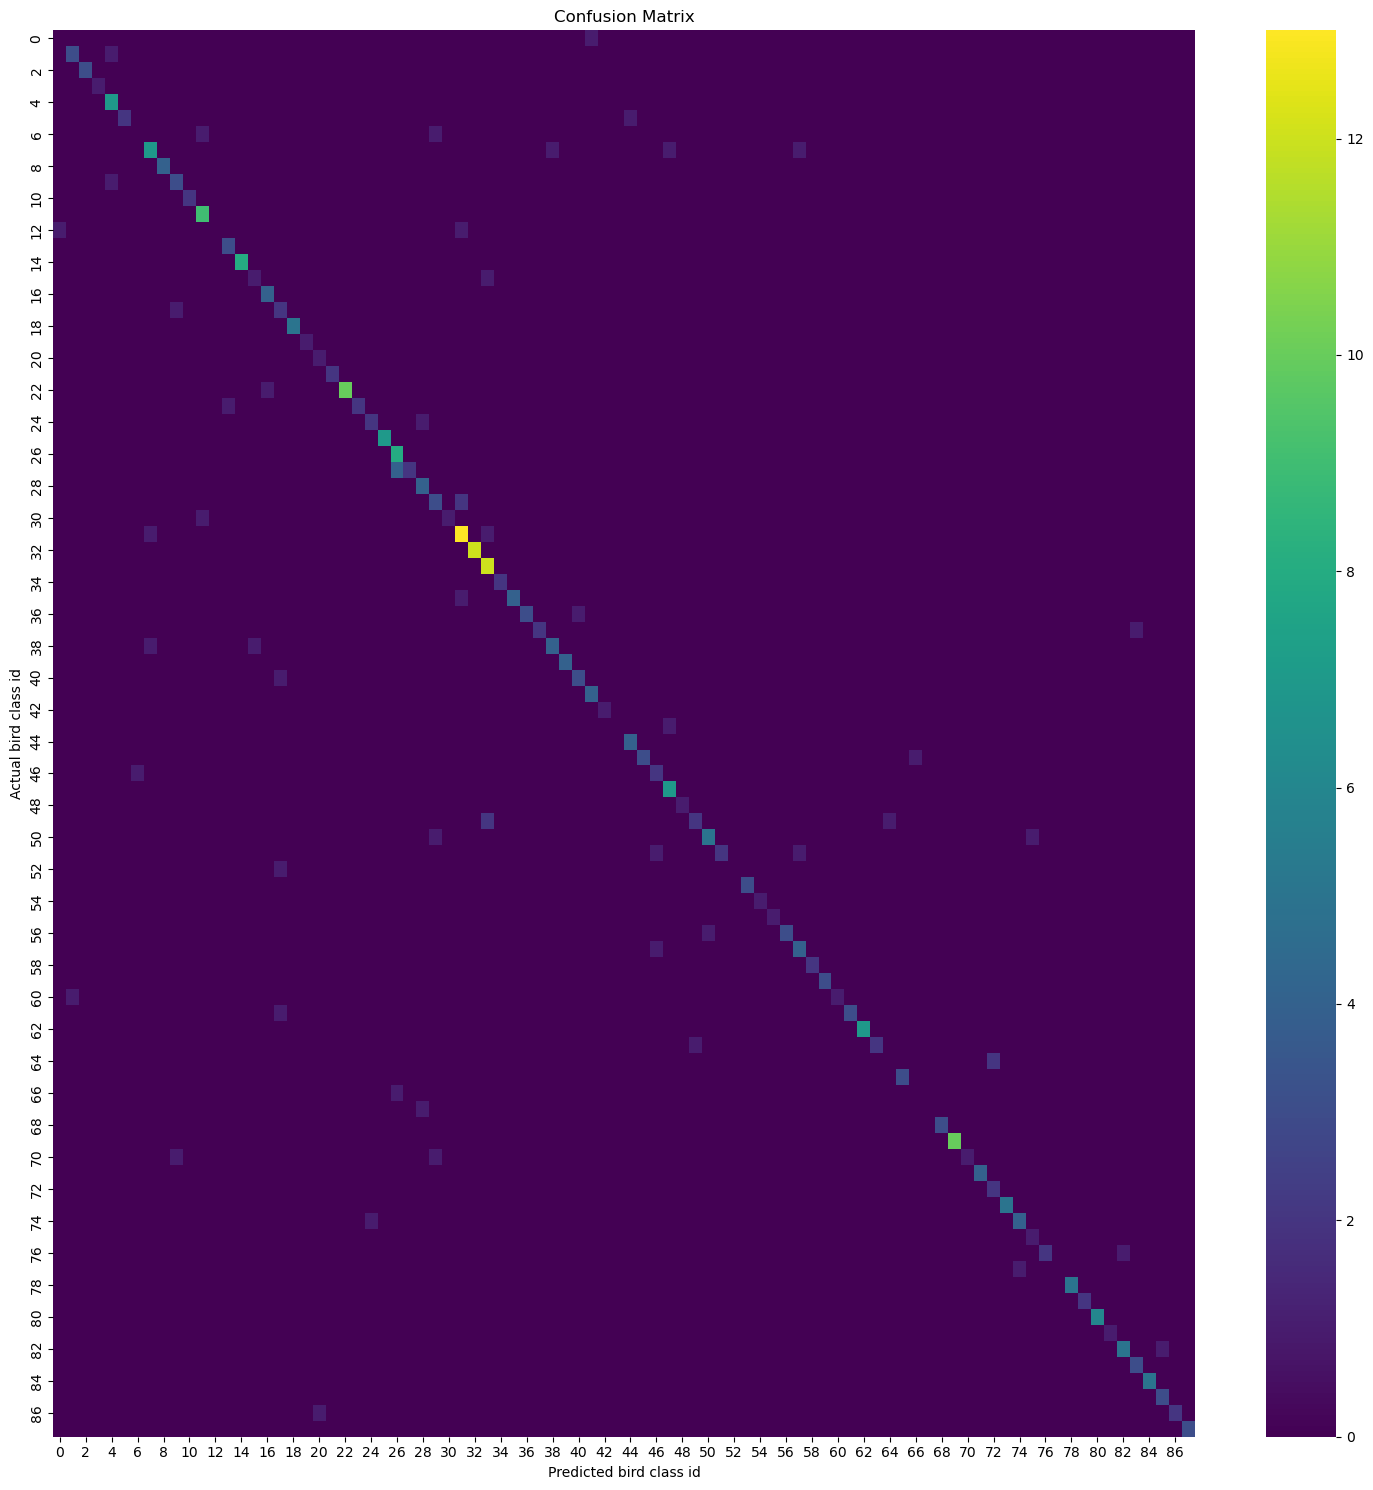

In [52]:
#plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix, cmap="viridis", cbar=True)
plt.xlabel("Predicted bird class id")
plt.ylabel("Actual bird class id")
plt.title("Confusion Matrix")
# Add tight layout
plt.tight_layout()
plt.savefig('Models\confusion_matrix_model_2.png')
plt.show()

In [51]:
#print the classes for which the classifier does not perform well (threshold can be triggered when to few number of samples)
for i, row in enumerate(modelTester.get_confusion_matrix()): 
    true_postivies = row[i]
    actual_positives = sum(row)
    false_negative = actual_positives - true_postivies

    if true_postivies < actual_positives * 0.7: 
        print(f"Class_id: {i}, true positive: {row[i]}, false negative: {false_negative}, total postivies: {actual_positives}")

Class_id: 0, true positive: 0, false negative: 1, total postivies: 1
Class_id: 5, true positive: 2, false negative: 1, total postivies: 3
Class_id: 6, true positive: 0, false negative: 2, total postivies: 2
Class_id: 12, true positive: 0, false negative: 2, total postivies: 2
Class_id: 15, true positive: 1, false negative: 1, total postivies: 2
Class_id: 17, true positive: 2, false negative: 1, total postivies: 3
Class_id: 23, true positive: 2, false negative: 1, total postivies: 3
Class_id: 24, true positive: 2, false negative: 1, total postivies: 3
Class_id: 27, true positive: 2, false negative: 4, total postivies: 6
Class_id: 29, true positive: 3, false negative: 2, total postivies: 5
Class_id: 30, true positive: 1, false negative: 1, total postivies: 2
Class_id: 37, true positive: 2, false negative: 1, total postivies: 3
Class_id: 38, true positive: 4, false negative: 2, total postivies: 6
Class_id: 43, true positive: 0, false negative: 1, total postivies: 1
Class_id: 46, true posi